In this part we'll work with our target, 'emission', as time series, calculating trend, seasonality, cycles, etc. We won't use features here.

Let's load datasets.

In [59]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_full = pd.read_csv('datasets/train.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'emission', 'year', 'week_no', 'latitude', 'longitude'])
location_group_train = pd.read_csv('new_datasets/train_and_cv_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
train_full['Location_group'] = location_group_train
test = pd.read_csv('datasets/test.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                        usecols=['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no', 'latitude', 'longitude'])
location_group_test = pd.read_csv('new_datasets/test_unfilled_1_final.csv', index_col='ID_LAT_LON_YEAR_WEEK',
                                usecols=['ID_LAT_LON_YEAR_WEEK', 'Location_group'])
test["Location_group"] = location_group_test

test_weeks = 49


four_representatives = pd.read_csv('new_datasets/four_representatives.csv', index_col=0)
four_representatives.columns = ["Location"]
groups = ['Special 1', 'Special 2', 'High', 'Low']
four_representatives["Group"] = groups


# Create date feature
train_full['date'] = pd.to_datetime(train_full.year.astype(str), format='%Y') + \
                     pd.to_timedelta(train_full.week_no.mul(7).astype(str) + ' days')
test['date'] = pd.to_datetime(test.year.astype(str), format='%Y') + \
                     pd.to_timedelta(test.week_no.mul(7).astype(str) + ' days')

# Create Location feature
train_full["Location"] = train_full['latitude'].astype('string') + \
       train_full['longitude'].astype('string')
test["Location"] = test['latitude'].astype('string') + test['longitude'].astype('string')

# Pre-covid data
train_precovid = train_full[train_full['date'] < pd.to_datetime('2020-03-18')].copy(deep=True)
precovid_weeks = 53 + len(train_precovid[train_precovid['year'] == 2020]['week_no'].unique())

# Post-covid data
train = train_full[train_full['date'] >  pd.to_datetime('2020-08-26')].copy(deep=True)

## Add missing Location Group labels
groups_dictionary = {group: train_full.loc[train_full["Location_group"] == group, "Location"].unique() for group in groups}
for group in groups:
    train_full.loc[train_full["Location"].isin(groups_dictionary[group]), "Location_group"] = group


CPU times: total: 1.3 s
Wall time: 1.47 s


Let's plot 'emission' for representatives of four groups discovered in Part 1. For each representative we' look at all data and at post-covid data separately: 

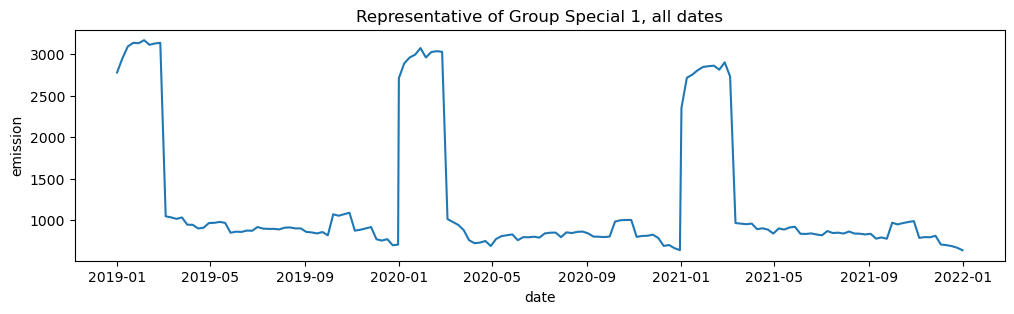

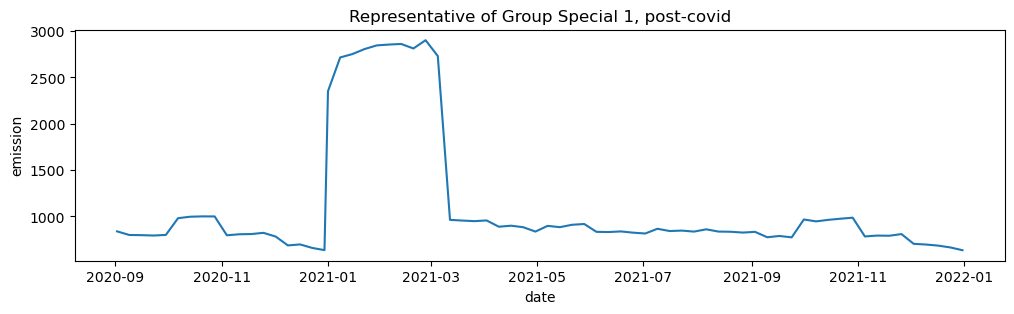

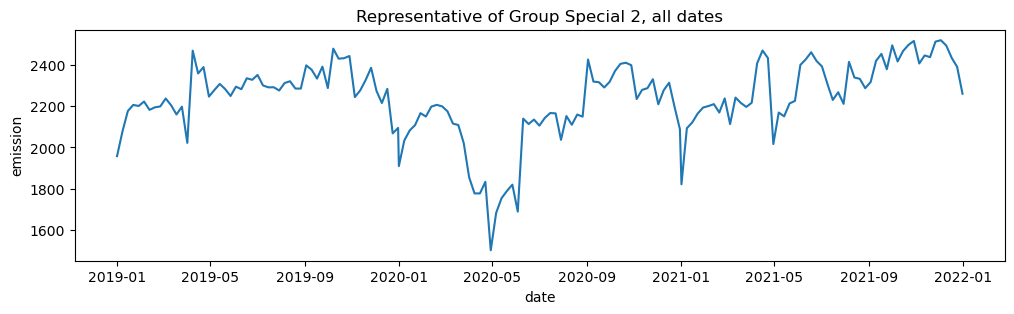

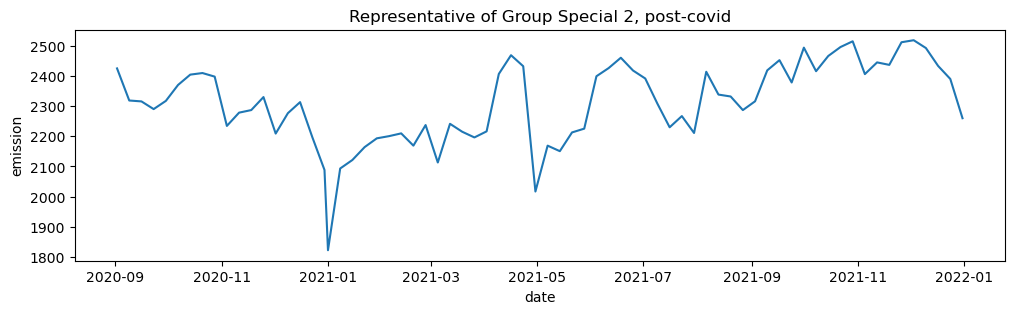

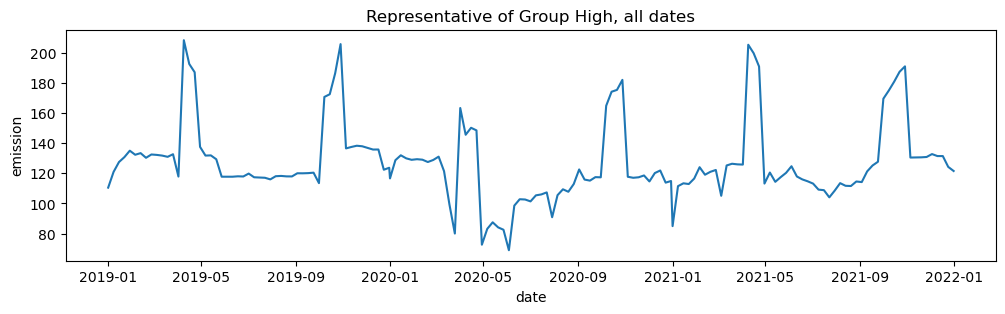

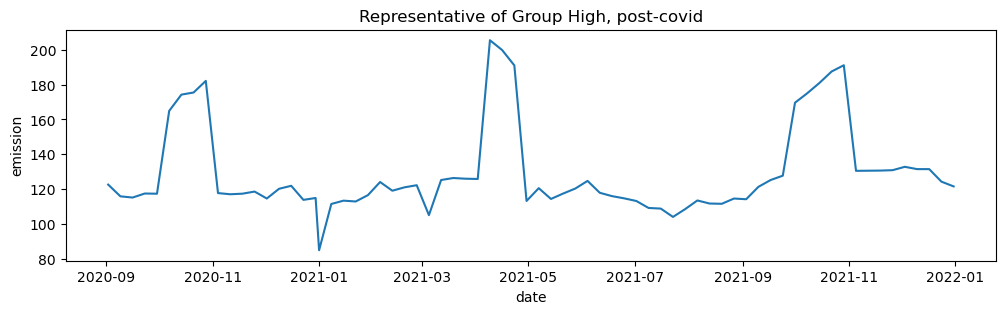

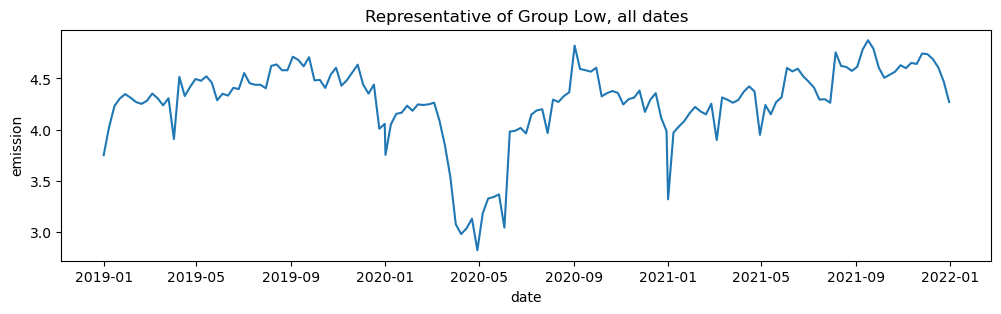

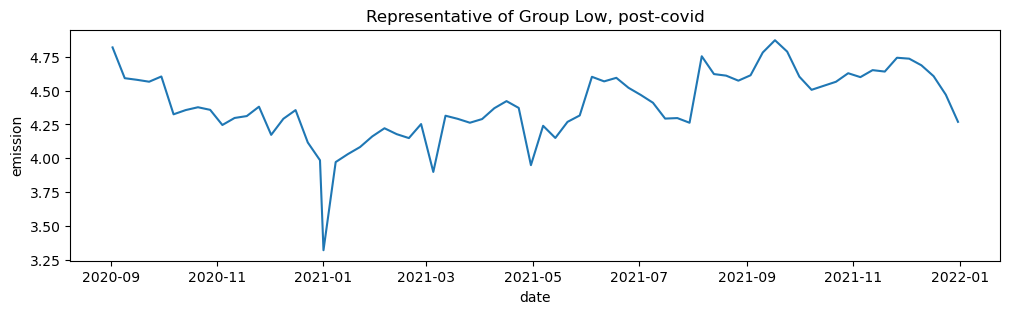

CPU times: total: 1.34 s
Wall time: 1.7 s


In [60]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns

for i, representative in four_representatives.iterrows():
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = train_full[train_full["Location"] == representative['Location']], x='date', y='emission').\
            set(title='Representative of Group {}, all dates'.format(representative["Group"]))
    plt.show()
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = train[train["Location"] == representative['Location']], x='date', y='emission').\
            set(title='Representative of Group {}, post-covid'.format(representative["Group"]))
    plt.show()

Our strategy will be to use the post-covid data only, except for trend and seasonality for Special 1, for which we'll use all data (post-covid data is not representative).

## 00. Trend

In [61]:
%%time

study_number = '00'

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

locations_count=0

for location in train['Location'].unique():
    #Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    train_precovid_index = train_precovid[train_precovid['Location'] == location].index
    train_index = train[train['Location'] == location].index
    test_index = test[test['Location'] == location].index
    
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
        # Create time series
        series = pd.Series(train_full.loc[train_full_index, 'emission'].values, \
                   index=train_full.loc[train_full_index, 'date'])

    ## For other locations
    else:
        # Create time series
        series = pd.Series(train.loc[train_index, 'emission'].values, \
                   index=train.loc[train_index, 'date'])
        
    series.index = series.index.to_period('W')    
    
    ## Calculate trend on the training set
    dp = DeterministicProcess(index=series.index, constant=True, order=1, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)

    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=train_full_index)
        train_full.loc[train_full_index, 'Trend'] = y_pred
        train.loc[train_index, 'Trend'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Trend'] = y_pred
        
    # Continue trend on pre-covid data
    X = dp.out_of_sample(steps=precovid_weeks)
    y_pred = pd.Series(lr.predict(X), index=train_precovid_index)
    train_precovid.loc[train_precovid_index, 'Trend'] = y_pred 
    
    # Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Trend'] = y_pred

    locations_count +=1
    # print(locations_count)



CPU times: total: 9.38 s
Wall time: 10.6 s


Let's look at the trend examples:

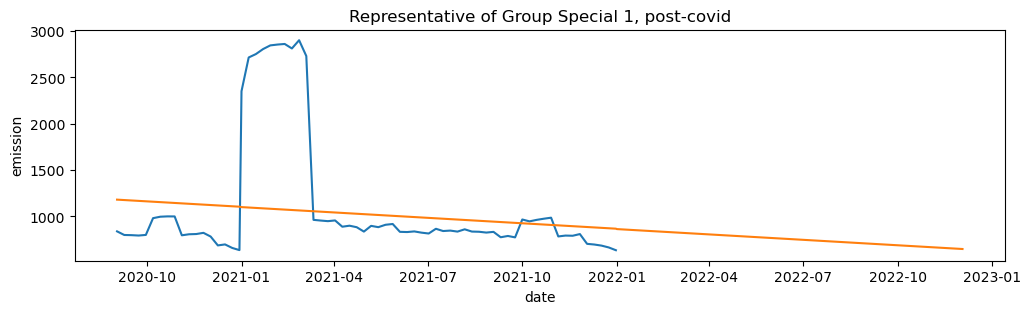

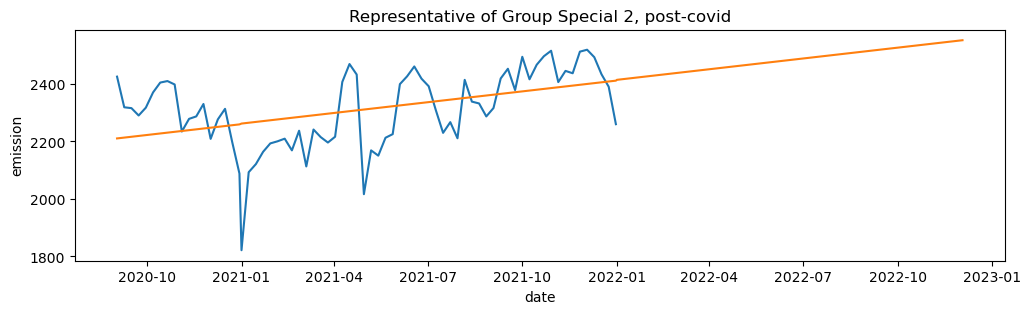

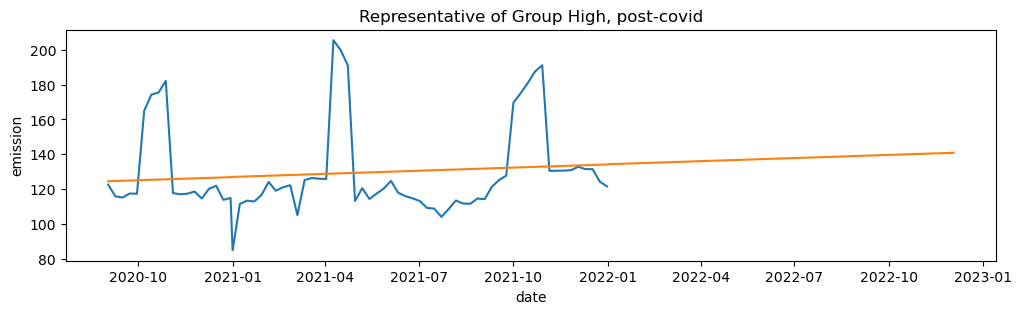

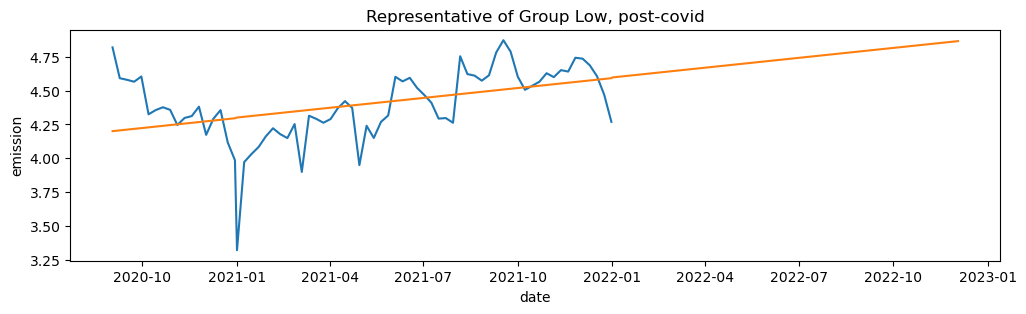

CPU times: total: 1.11 s
Wall time: 1.38 s


In [62]:
%%time

train_and_test = pd.concat([train, test])

for i, representative in four_representatives.iterrows():
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = train_and_test[train_and_test["Location"] == representative['Location']], x='date', y='emission')
    sns.lineplot(data = train_and_test[train_and_test["Location"] == representative['Location']], x='date', y='Trend').\
            set(title='Representative of Group {}, post-covid'.format(representative["Group"]))
    plt.show()

Let's look at the errors:

In [63]:
%%time

from sklearn.metrics import mean_squared_error

# Create scores DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Test RMSE': []})

# Calculate train RMSE
score_train = mean_squared_error(train['emission'], train['Trend'], squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['Trend']})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)


CPU times: total: 31.2 ms
Wall time: 52.1 ms


In [64]:
# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'Trend'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Test RMSE'] = 70.22941

scores_df

,Comment,Train RMSE,Test RMSE
0,Trend,39.010435,70.22941


Let's create the detrended feature:

In [65]:
for data in [train, train_precovid, train_full]:
    data['emission_2_' + study_number] = data['emission'] - data['Trend']
    
train_precovid.head()

,latitude,longitude,year,week_no,emission,Location_group,date,Location,Trend,emission_2_00
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,3.750994,Low,2019-01-01,-0.5129.29,4.598075,-0.847081
ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,4.025176,Low,2019-01-08,-0.5129.29,4.603672,-0.578496
ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,4.231381,Low,2019-01-15,-0.5129.29,4.609270,-0.377889
ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,4.305286,Low,2019-01-22,-0.5129.29,4.614867,-0.309581
ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,4.347317,Low,2019-01-29,-0.5129.29,4.620464,-0.273147


## 01. Seasonality

Let's look at periodograms of the detrended emission time series for our representatives:

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


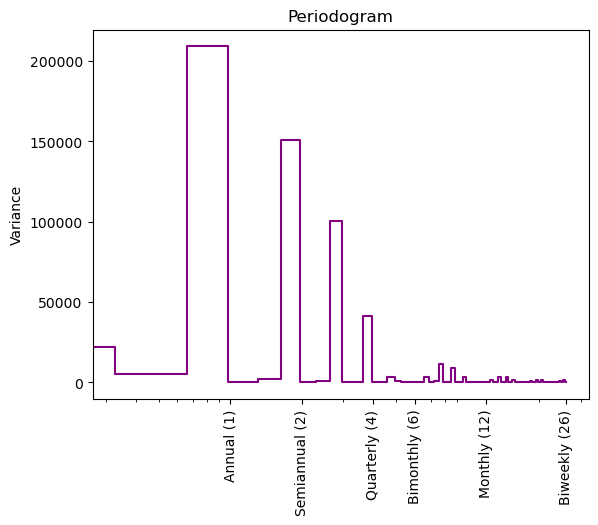

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


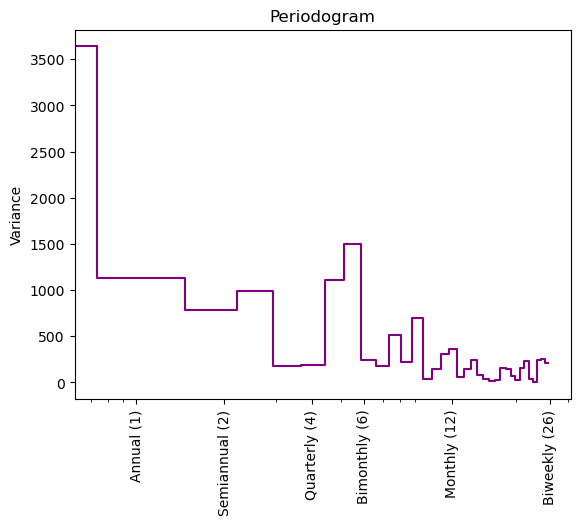

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


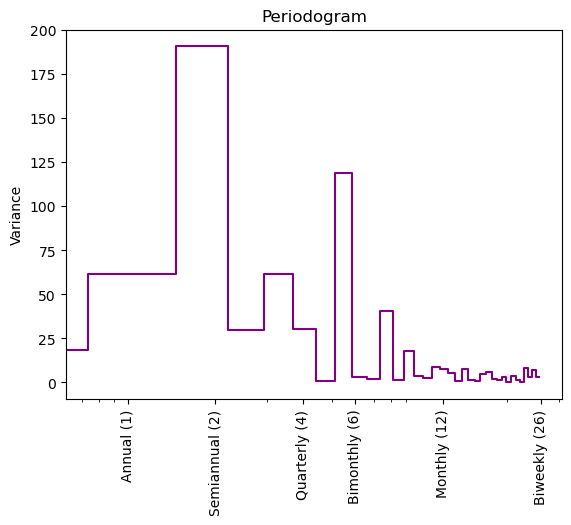

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


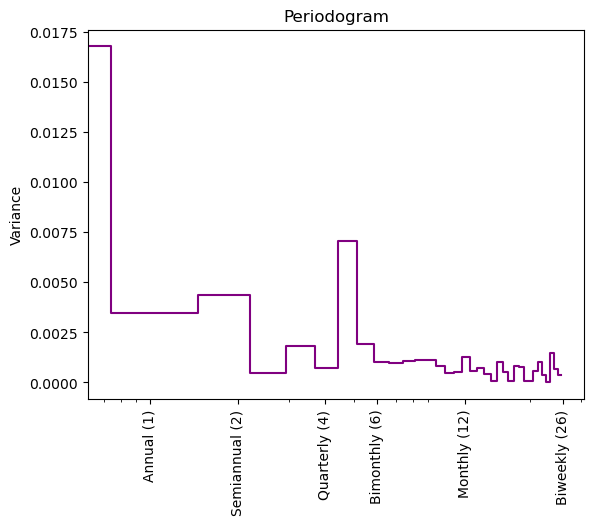

CPU times: total: 828 ms
Wall time: 1.02 s


In [66]:
%%time

study_number = '01'

from functions.plot_periodogram import plot_periodogram


for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission_2_00'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(train.loc[train['Location'] == location, 'emission_2_00'].values, \
                   index=train.loc[train['Location'] == location, 'date']) 
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()
    


We'll use annual seasonality with 4 Fourier pairs for the Special 1 location, 9 pairs for High locations and 6 pairs for others:

In [67]:
%%time


from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

locations_count=0

for location in train['Location'].unique():
    #Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    train_precovid_index = train_precovid[train_precovid['Location'] == location].index
    train_index = train[train['Location'] == location].index
    test_index = test[test['Location'] == location].index
    
    ## Create time series
    # For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
        series = pd.Series(train_full.loc[train_full_index, 'emission_2_00'].values, \
                   index=train_full.loc[train_full_index, 'date'])
    # For other locations
    else:
        # Create time series
        series = pd.Series(train.loc[train_index, 'emission_2_00'].values, \
                   index=train.loc[train_index, 'date'])
    
    series.index = series.index.to_period('W') 
    
    ## sin/cos pairs for annual seasonality
    if location in groups_dictionary['Special 1']:
        pairs = 4
    elif location in groups_dictionary['Special 2']:
        pairs = 9
    elif location in groups_dictionary['High']:
        pairs = 9
    elif location in groups_dictionary['Low']:
        pairs = 6
    else:
        raise ValueError('A location does not belong to any group.')
        
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=train_full_index)
        train_full.loc[train_full_index, 'Seasonality'] = y_pred
        train.loc[train_index, 'Seasonality'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Seasonality'] = y_pred
        
    # Continue trend on pre-covid data
    X = dp.out_of_sample(steps=precovid_weeks)
    y_pred = pd.Series(lr.predict(X), index=train_precovid_index)
    train_precovid.loc[train_precovid_index, 'Seasonality'] = y_pred 
    
    # Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Seasonality'] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 52.6 s
Wall time: 14.6 s


Let's create the detrended and deseasonalized feature. Also, let's calculate predictions:

In [68]:
for data in [train_precovid, train, train_full]:
    data['emission_2_' + study_number] = data['emission'] - data['Trend'] - data['Seasonality']
    data['emission_pred_2_' + study_number] = data['Trend'] + data['Seasonality']
    
test['emission_pred_2_' + study_number] = test['Trend'] + test['Seasonality']
    
train.head()

,latitude,longitude,year,week_no,emission,Location_group,date,Location,Trend,emission_2_00,Seasonality,emission_2_01,emission_pred_2_01
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,
ID_-0.510_29.290_2020_35,-0.51,29.29,2020,35,4.820261,Low,2020-09-02,-0.5129.29,4.200676,0.619586,0.336200,0.283386,4.536875
ID_-0.510_29.290_2020_36,-0.51,29.29,2020,36,4.592424,Low,2020-09-09,-0.5129.29,4.206273,0.386151,0.341477,0.044674,4.547750
ID_-0.510_29.290_2020_37,-0.51,29.29,2020,37,4.580510,Low,2020-09-16,-0.5129.29,4.211870,0.368640,0.328166,0.040474,4.540036
ID_-0.510_29.290_2020_38,-0.51,29.29,2020,38,4.566356,Low,2020-09-23,-0.5129.29,4.217467,0.348889,0.295757,0.053131,4.513225
ID_-0.510_29.290_2020_39,-0.51,29.29,2020,39,4.605026,Low,2020-09-30,-0.5129.29,4.223064,0.381962,0.243489,0.138473,4.466554


Let's look at seasonality plots for our representatives:

Group: Special 1


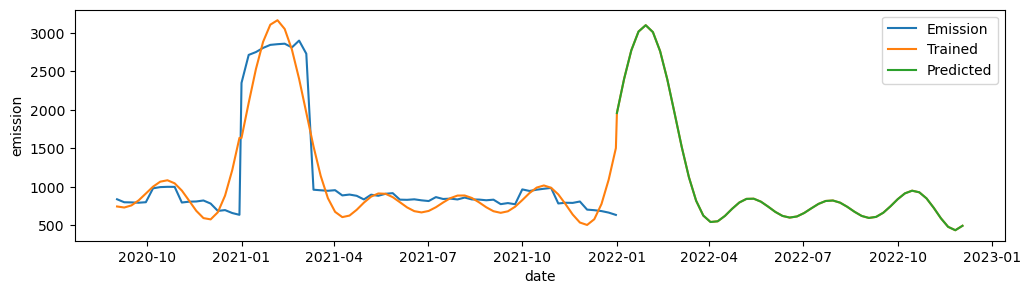

Group: Special 2


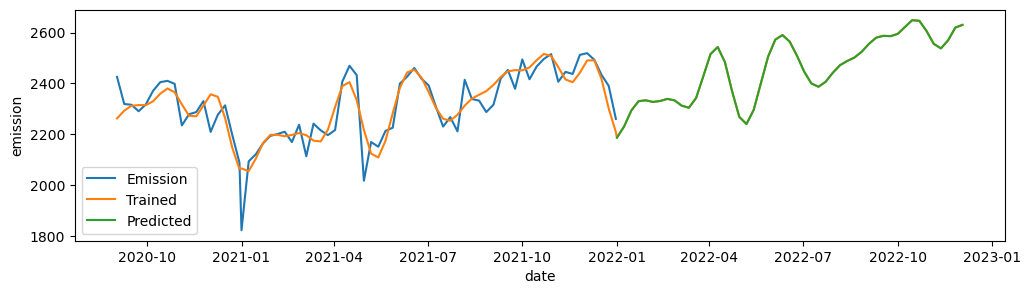

Group: High


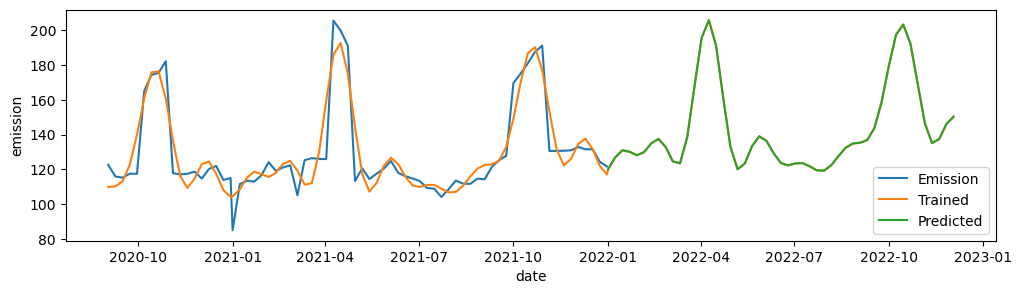

Group: Low


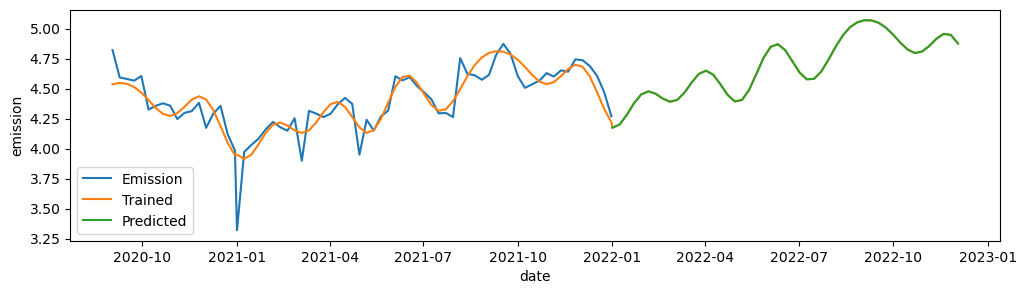

CPU times: total: 1.25 s
Wall time: 997 ms


In [69]:
%%time

train_and_test = pd.concat([train, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train[train['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_test[train_and_test['Location'] == location],
                 x='date', y='emission_pred_2_{}'.format(study_number), label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                 y='emission_pred_2_{}'.format(study_number), label='Predicted')
    plt.show()
    

Let's make a submission and look at the RMSEs:

In [70]:
# Calculate train RMSE
score_train = mean_squared_error(train['emission'], train['emission_pred_2_{}'.format(study_number)], squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['emission_pred_2_{}'.format(study_number)]})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [71]:
# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = '+ Seasonality'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Test RMSE'] = 28.26862

scores_df

,Comment,Train RMSE,Test RMSE
0,Trend,39.010435,70.22941
1,+ Seasonality,16.224511,28.26862


Let's look at the graphs of residues:

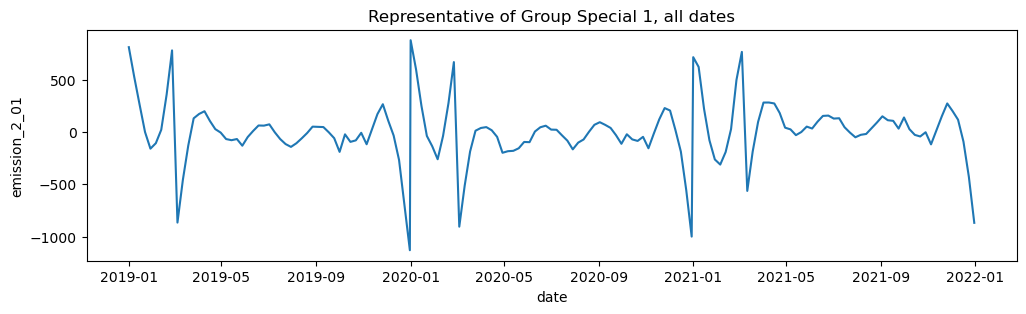

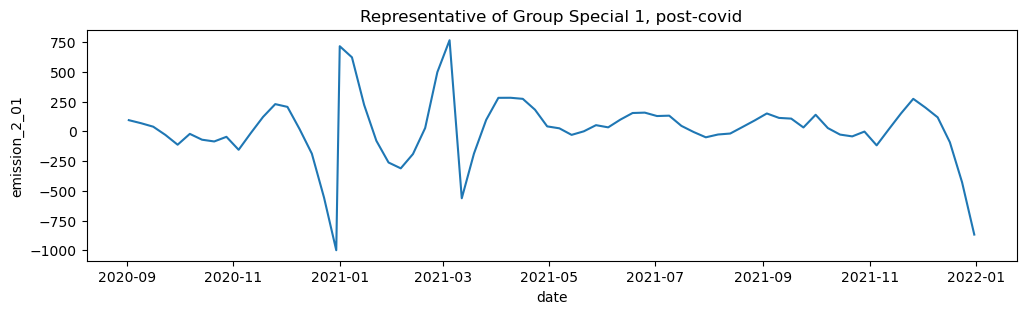

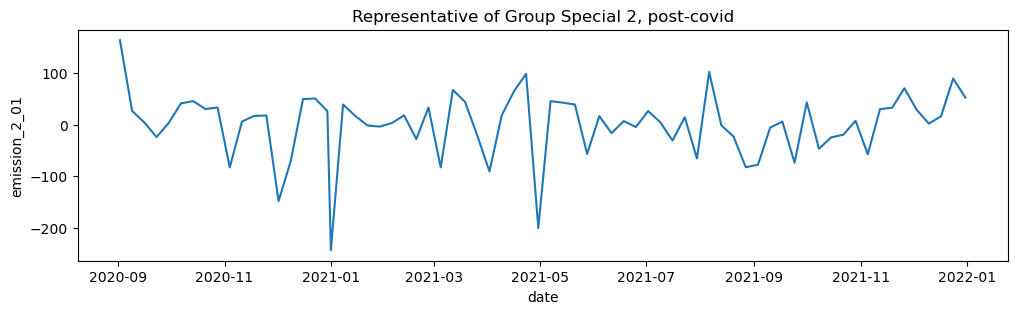

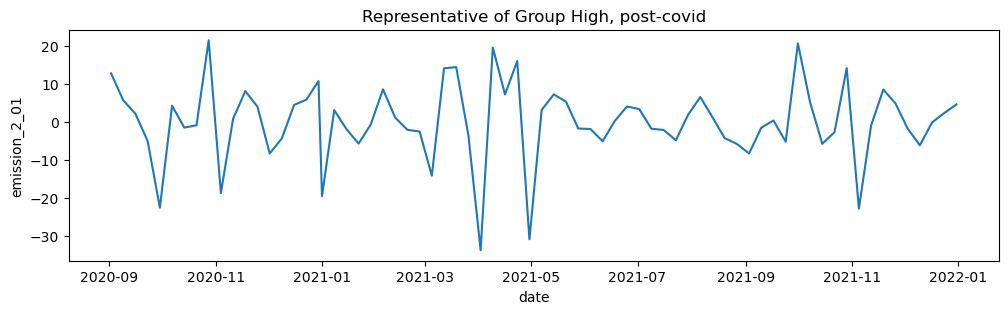

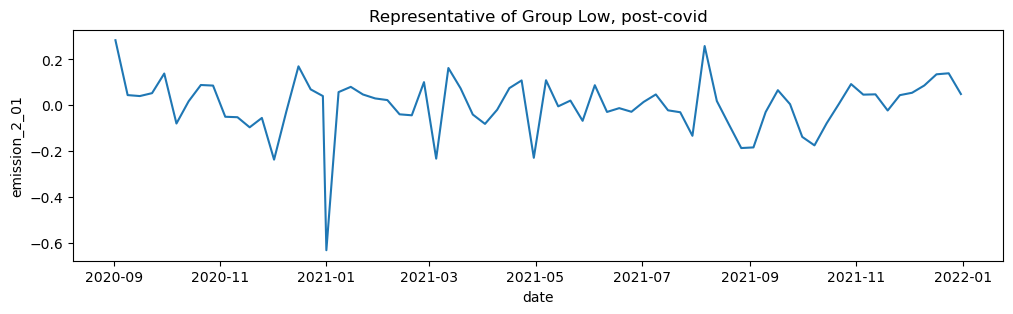

CPU times: total: 844 ms
Wall time: 1.02 s


In [72]:
%%time

fig, ax = plt.subplots(figsize=(12, 3))
    
sns.lineplot(data = train_full[train_full["Location"] == four_representatives.iloc[0,0]], x='date', y='emission_2_01').\
        set(title='Representative of Group {}, all dates'.format(four_representatives.iloc[0,1]))
plt.show()

for i, representative in four_representatives.iterrows():
    
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = train[train["Location"] == representative['Location']], x='date', y='emission_2_01').\
            set(title='Representative of Group {}, post-covid'.format(representative["Group"]))
    plt.show()

We didn't remove all the seasonality. Let's do another round.

## 02. Seasonality_2

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


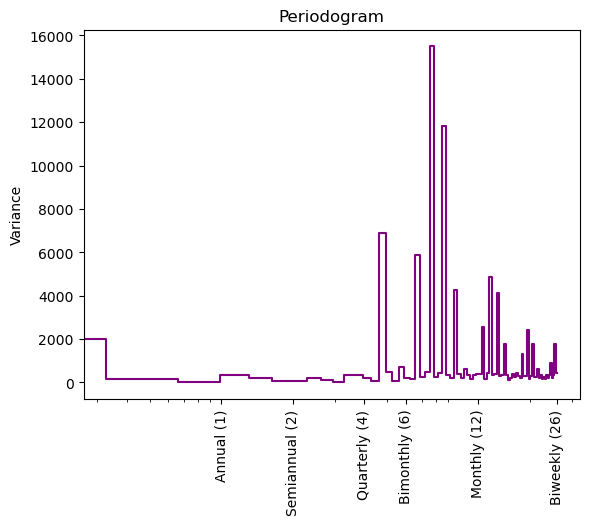

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


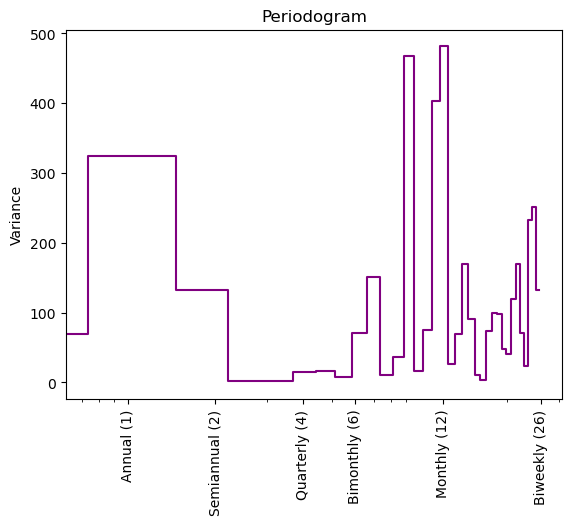

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


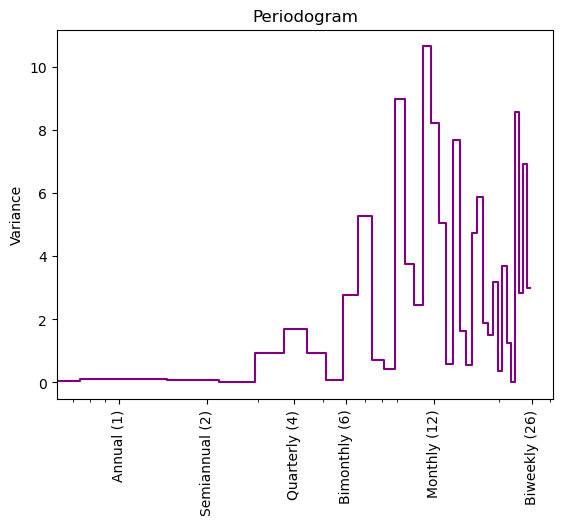

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


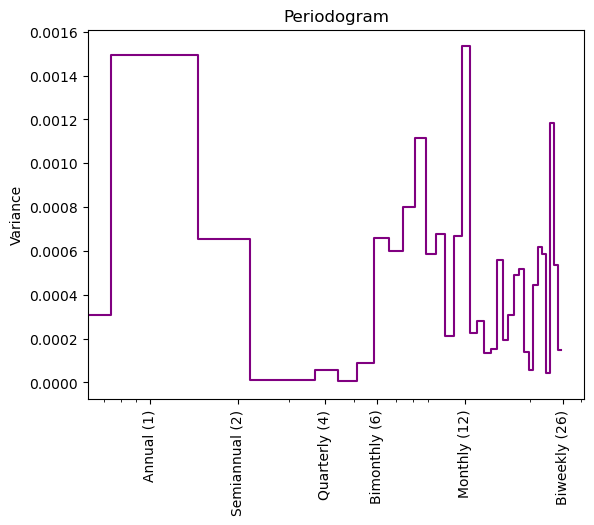

In [73]:
study_number = '02'

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission_2_01'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(train.loc[train['Location'] == location, 'emission_2_01'].values, \
                   index=train.loc[train['Location'] == location, 'date']) 
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

Here we'll try quarterly seasonality.

In [74]:
%%time

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

locations_count=0

for location in train['Location'].unique():
    #Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    train_precovid_index = train_precovid[train_precovid['Location'] == location].index
    train_index = train[train['Location'] == location].index
    test_index = test[test['Location'] == location].index
    
    ## Create time series
    # For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
        series = pd.Series(train_full.loc[train_full_index, 'emission_2_01'].values, \
                   index=train_full.loc[train_full_index, 'date'])
    # For other locations
    else:
        # Create time series
        series = pd.Series(train.loc[train_index, 'emission_2_01'].values, \
                   index=train.loc[train_index, 'date'])
    
    series.index = series.index.to_period('W') 
    
    ## sin/cos pairs for annual seasonality
    if location in groups_dictionary['Special 1']:
        pairs = 3
    elif location in groups_dictionary['Special 2']:
        pairs = 3
    elif location in groups_dictionary['High']:
        pairs = 3
    elif location in groups_dictionary['Low']:
        pairs = 3
    else:
        raise ValueError('A location does not belong to any group.') 
    fourier = CalendarFourier(freq="Q", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=train_full_index)
        train_full.loc[train_full_index, 'Seasonality_2'] = y_pred
        train.loc[train_index, 'Seasonality_2'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Seasonality_2'] = y_pred
        
    # Continue trend on pre-covid data
    X = dp.out_of_sample(steps=precovid_weeks)
    y_pred = pd.Series(lr.predict(X), index=train_precovid_index)
    train_precovid.loc[train_precovid_index, 'Seasonality_2'] = y_pred 
    
    # Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Seasonality_2'] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 11.9 s
Wall time: 14.1 s


In [75]:
for data in [train_precovid, train, train_full]:
    data['emission_2_' + study_number] = data['emission'] - data['Trend'] - data['Seasonality'] - data['Seasonality_2']
    data['emission_pred_2_' + study_number] = data['Trend'] + data['Seasonality'] + data['Seasonality_2']
    
test['emission_pred_2_' + study_number] = test['Trend'] + test['Seasonality'] + test['Seasonality_2']
    
train.head()

,latitude,longitude,year,week_no,emission,Location_group,date,Location,Trend,emission_2_00,Seasonality,emission_2_01,emission_pred_2_01,Seasonality_2,emission_2_02,emission_pred_2_02
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2020_35,-0.51,29.29,2020,35,4.820261,Low,2020-09-02,-0.5129.29,4.200676,0.619586,0.336200,0.283386,4.536875,-0.024551,0.307937,4.512325
ID_-0.510_29.290_2020_36,-0.51,29.29,2020,36,4.592424,Low,2020-09-09,-0.5129.29,4.206273,0.386151,0.341477,0.044674,4.547750,0.061376,-0.016702,4.609126
ID_-0.510_29.290_2020_37,-0.51,29.29,2020,37,4.580510,Low,2020-09-16,-0.5129.29,4.211870,0.368640,0.328166,0.040474,4.540036,0.074348,-0.033873,4.614383
ID_-0.510_29.290_2020_38,-0.51,29.29,2020,38,4.566356,Low,2020-09-23,-0.5129.29,4.217467,0.348889,0.295757,0.053131,4.513225,-0.004415,0.057546,4.508810
ID_-0.510_29.290_2020_39,-0.51,29.29,2020,39,4.605026,Low,2020-09-30,-0.5129.29,4.223064,0.381962,0.243489,0.138473,4.466554,-0.068100,0.206573,4.398453


Group: Special 1


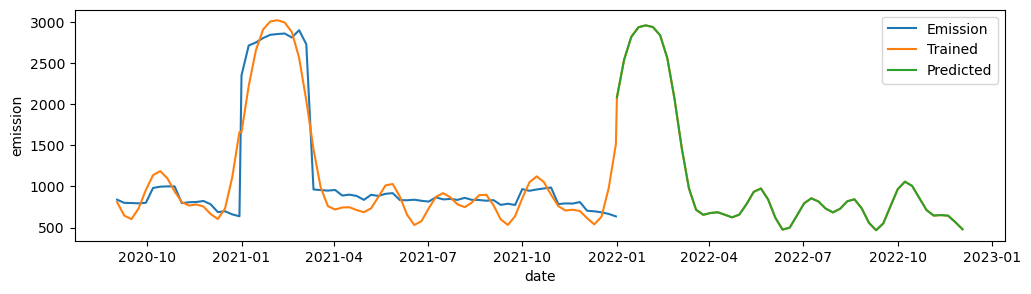

Group: Special 2


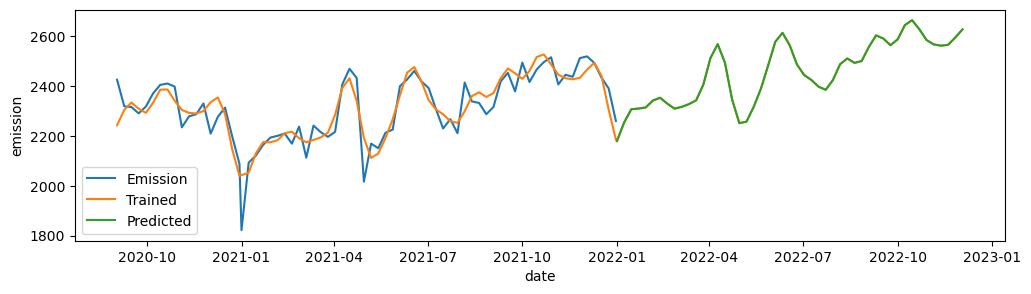

Group: High


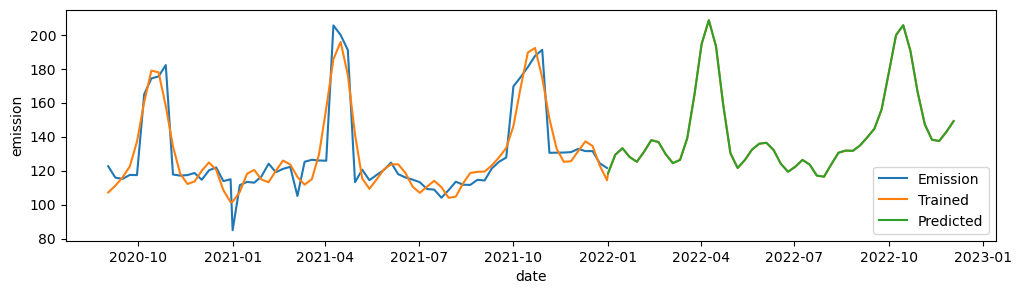

Group: Low


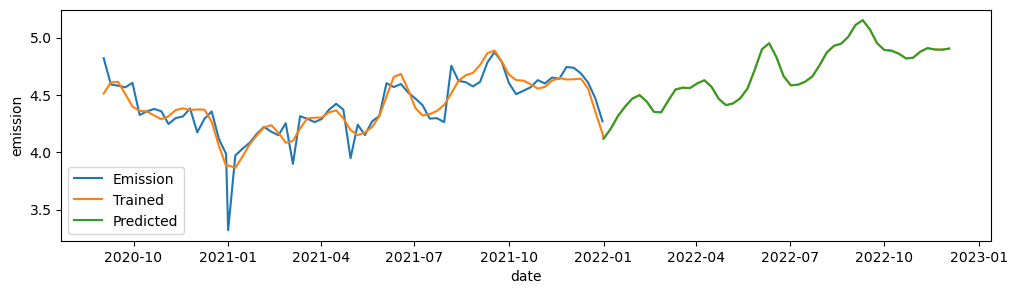

CPU times: total: 859 ms
Wall time: 1.1 s


In [76]:
%%time

train_and_test = pd.concat([train, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train[train['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_test[train_and_test['Location'] == location],
                 x='date', y='emission_pred_2_{}'.format(study_number), label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                 y='emission_pred_2_{}'.format(study_number), label='Predicted')
    plt.show()
    

In [77]:
# Calculate train RMSE
score_train = mean_squared_error(train['emission'], train['emission_pred_2_{}'.format(study_number)], squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['emission_pred_2_{}'.format(study_number)]})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [78]:
# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = '+ Seasonality_2'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Test RMSE'] = 27.7878

scores_df

,Comment,Train RMSE,Test RMSE
0,Trend,39.010435,70.22941
1,+ Seasonality,16.224511,28.26862
2,+ Seasonality_2,15.360794,27.78780


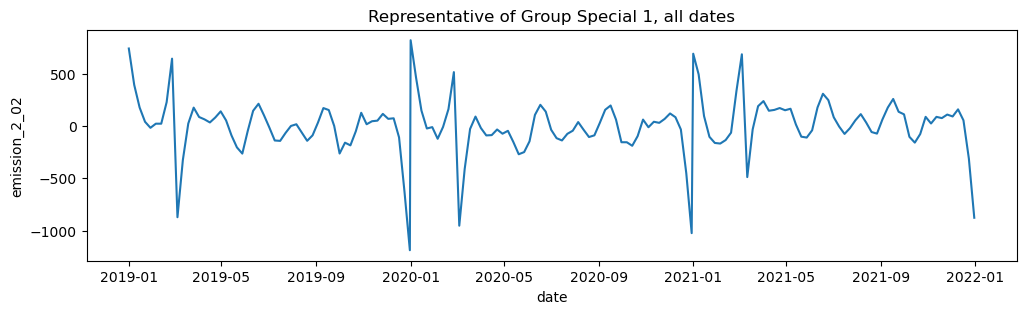

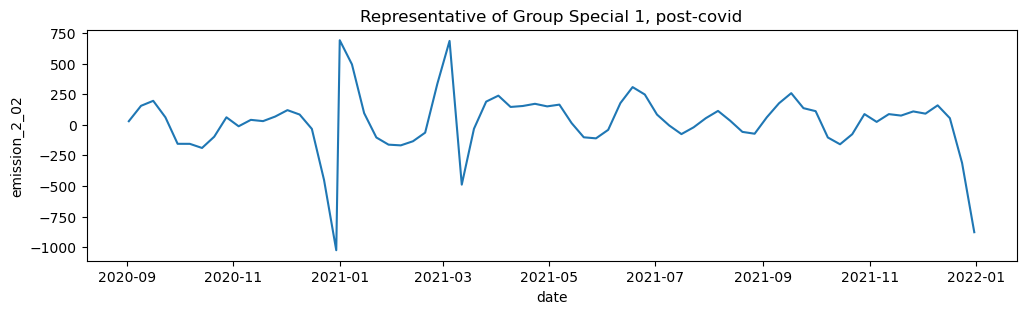

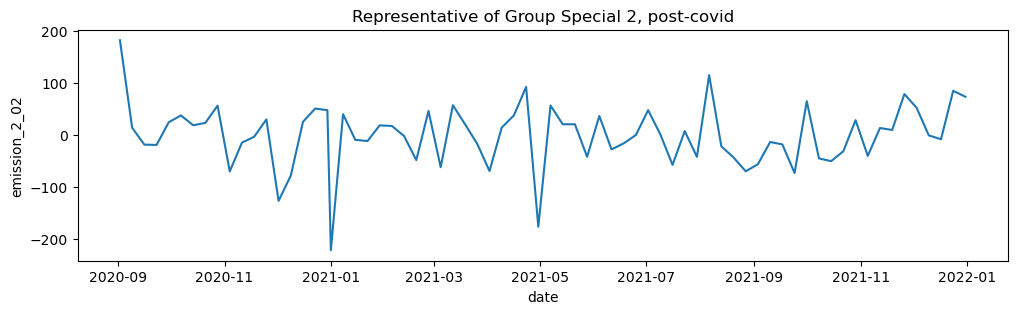

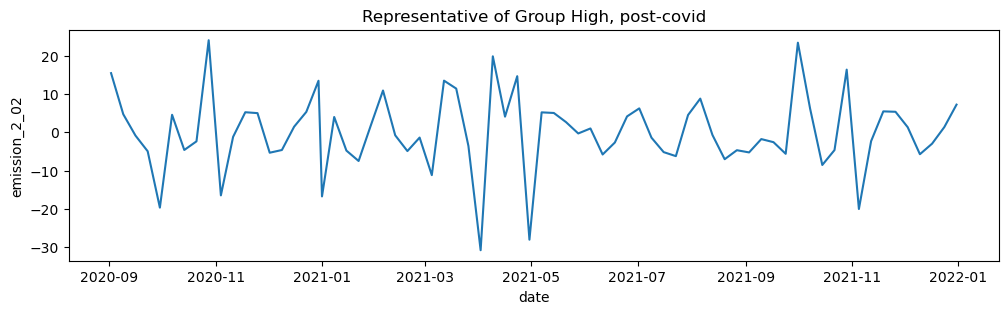

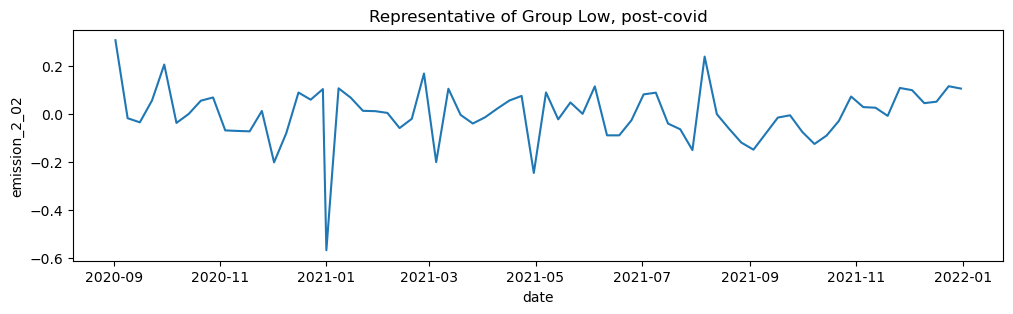

CPU times: total: 875 ms
Wall time: 1.11 s


In [79]:
%%time

fig, ax = plt.subplots(figsize=(12, 3))
    
sns.lineplot(data = train_full[train_full["Location"] == four_representatives.iloc[0,0]], x='date', y='emission_2_02').\
        set(title='Representative of Group {}, all dates'.format(four_representatives.iloc[0,1]))
plt.show()

for i, representative in four_representatives.iterrows():
    
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = train[train["Location"] == representative['Location']], x='date', y='emission_2_02').\
            set(title='Representative of Group {}, post-covid'.format(representative["Group"]))
    plt.show()

How about a third round?

## 03. Seasonality_3

Group: Special 1


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


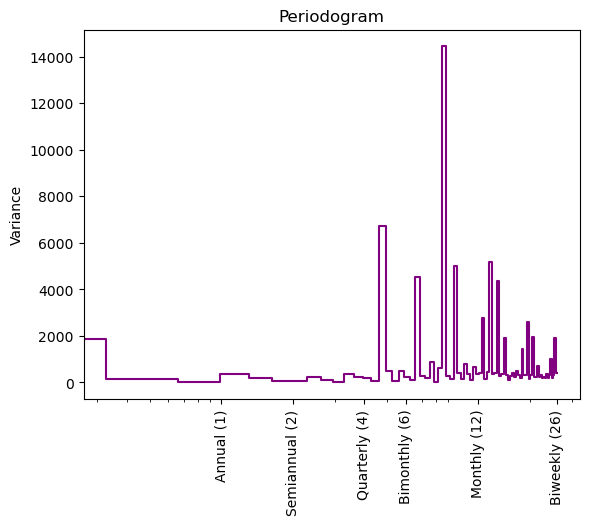

Group: Special 2


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


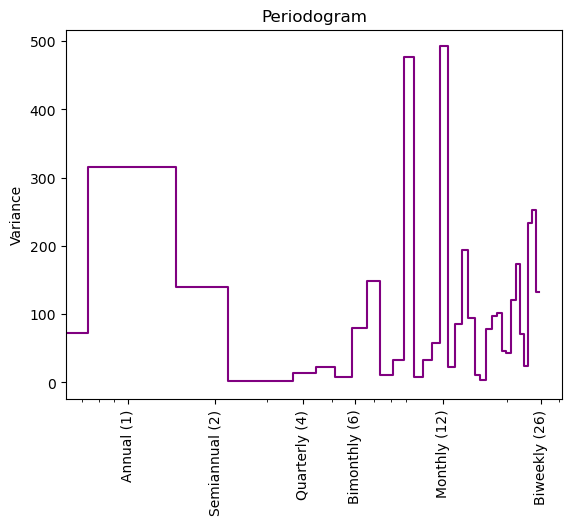

Group: High


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


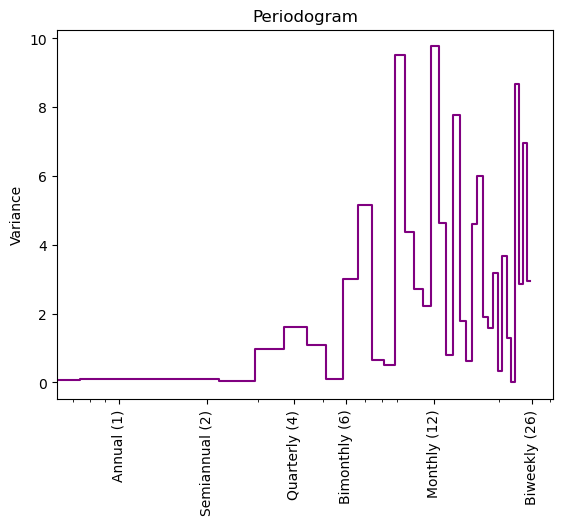

Group: Low


C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


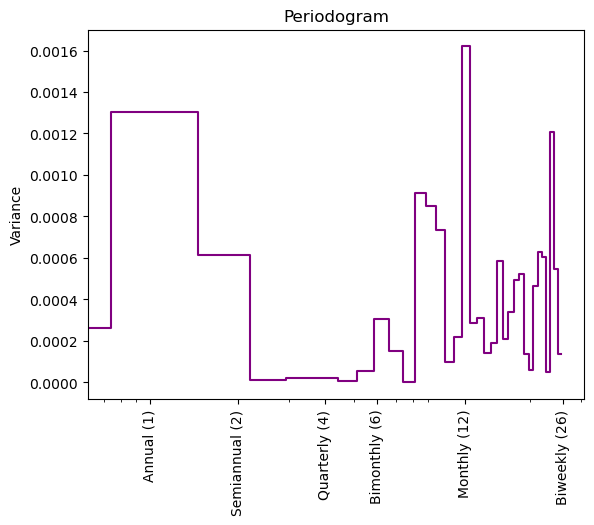

In [80]:
study_number = '03'

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
    
        series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission_2_02'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date']) 
    ## For others
    else:
        series = pd.Series(train.loc[train['Location'] == location, 'emission_2_02'].values, \
                   index=train.loc[train['Location'] == location, 'date']) 
        
    series.index = series.index.to_period('W')
    plot_periodogram(series)
    plt.show()

In [81]:
%%time

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

locations_count=0

for location in train['Location'].unique():
    #Save indices
    train_full_index = train_full[train_full['Location'] == location].index
    train_precovid_index = train_precovid[train_precovid['Location'] == location].index
    train_index = train[train['Location'] == location].index
    test_index = test[test['Location'] == location].index
    ## For the 'Special 1' location
    if location == four_representatives.iloc[0, 0]:
        # Create time series
        series = pd.Series(train_full.loc[train_full['Location'] == location, 'emission_2_02'].values, \
                   index=train_full.loc[train_full['Location'] == location, 'date'])
        # sin/cos pairs for seasonality
        pairs = 2

    ## For other locations
    else:
        # Create time series
        series = pd.Series(train.loc[train['Location'] == location, 'emission_2_02'].values, \
                   index=train.loc[train['Location'] == location, 'date'])
        # sin/cos pairs for seasonality
        pairs = 2
        
    series.index = series.index.to_period('W')      
    fourier = CalendarFourier(freq="M", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    if location == four_representatives.iloc[0, 0]:
        y_pred = pd.Series(lr.predict(X), index=train_full_index)
        train_full.loc[train_full_index, 'Seasonality_3'] = y_pred
        train.loc[train_index, 'Seasonality_3'] = y_pred[train_index]
    else:
        y_pred = pd.Series(lr.predict(X), index=train_index)
        train.loc[train_index, 'Seasonality_3'] = y_pred
        
    # Continue trend on pre-covid data
    X = dp.out_of_sample(steps=precovid_weeks)
    y_pred = pd.Series(lr.predict(X), index=train_precovid_index)
    train_precovid.loc[train_precovid_index, 'Seasonality_3'] = y_pred 
    
    # Continue trend on the test set:
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=test_index)
    test.loc[test_index, 'Seasonality_3'] = y_pred

    locations_count +=1
    # print(locations_count)


CPU times: total: 12.6 s
Wall time: 13.8 s


In [82]:
for data in [train_precovid, train, train_full]:
    data['emission_2_' + study_number] = data['emission'] - data['Trend'] - data['Seasonality'] - data['Seasonality_2'] \
            - data['Seasonality_3']
    data['emission_pred_2_' + study_number] = data['Trend'] + data['Seasonality'] + data['Seasonality_2'] \
            + data['Seasonality_3']
    
test['emission_pred_2_' + study_number] = test['Trend'] + test['Seasonality'] + test['Seasonality_2'] \
            + test['Seasonality_3']
    
train.head()

,latitude,longitude,year,week_no,emission,Location_group,date,Location,Trend,emission_2_00,Seasonality,emission_2_01,emission_pred_2_01,Seasonality_2,emission_2_02,emission_pred_2_02,Seasonality_3,emission_2_03,emission_pred_2_03
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2020_35,-0.51,29.29,2020,35,4.820261,Low,2020-09-02,-0.5129.29,4.200676,0.619586,0.336200,0.283386,4.536875,-0.024551,0.307937,4.512325,0.001838,0.306099,4.514163
ID_-0.510_29.290_2020_36,-0.51,29.29,2020,36,4.592424,Low,2020-09-09,-0.5129.29,4.206273,0.386151,0.341477,0.044674,4.547750,0.061376,-0.016702,4.609126,0.001112,-0.017815,4.610239
ID_-0.510_29.290_2020_37,-0.51,29.29,2020,37,4.580510,Low,2020-09-16,-0.5129.29,4.211870,0.368640,0.328166,0.040474,4.540036,0.074348,-0.033873,4.614383,-0.010013,-0.023860,4.604370
ID_-0.510_29.290_2020_38,-0.51,29.29,2020,38,4.566356,Low,2020-09-23,-0.5129.29,4.217467,0.348889,0.295757,0.053131,4.513225,-0.004415,0.057546,4.508810,0.016849,0.040697,4.525659
ID_-0.510_29.290_2020_39,-0.51,29.29,2020,39,4.605026,Low,2020-09-30,-0.5129.29,4.223064,0.381962,0.243489,0.138473,4.466554,-0.068100,0.206573,4.398453,-0.014171,0.220744,4.384283


Group: Special 1


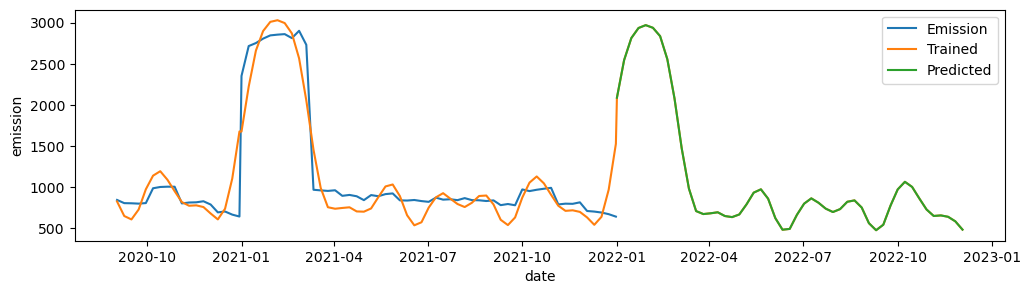

Group: Special 2


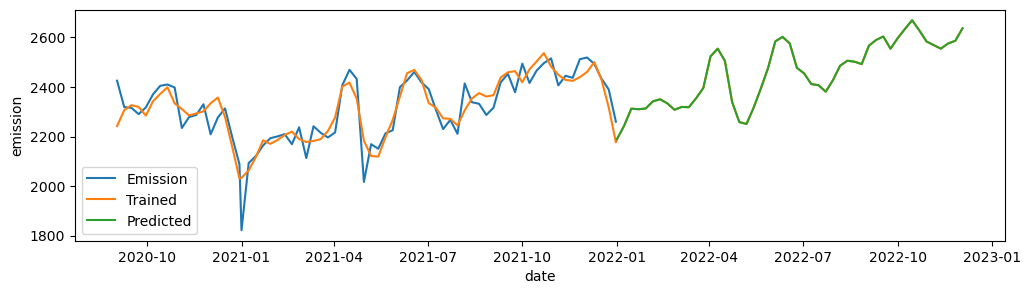

Group: High


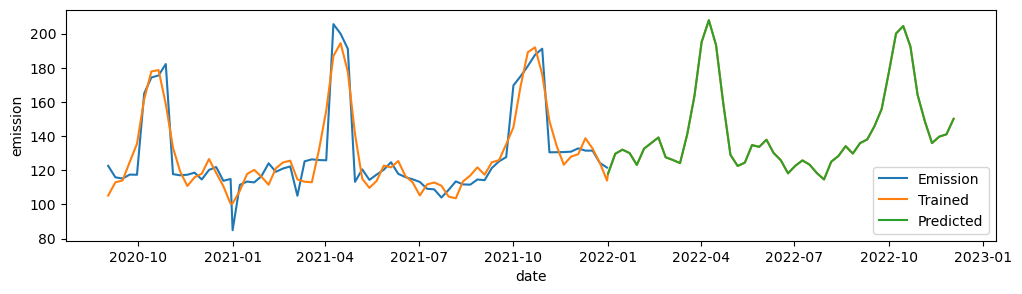

Group: Low


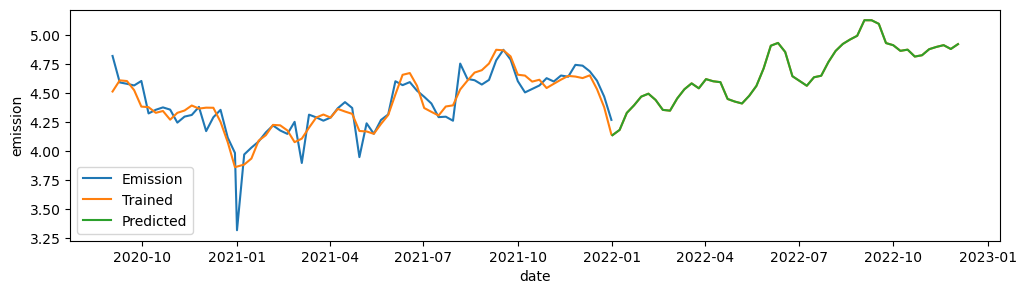

CPU times: total: 828 ms
Wall time: 1.05 s


In [83]:
%%time

train_and_test = pd.concat([train, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train[train['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_test[train_and_test['Location'] == location],
                 x='date', y='emission_pred_2_{}'.format(study_number), label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                 y='emission_pred_2_{}'.format(study_number), label='Predicted')
    plt.show()
    

In [84]:
# Calculate train RMSE
score_train = mean_squared_error(train['emission'], train['emission_pred_2_{}'.format(study_number)], squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['emission_pred_2_{}'.format(study_number)]})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [85]:
# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = '+ Seasonality_3'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Test RMSE
0,Trend,39.010435,70.22941
1,+ Seasonality,16.224511,28.26862
2,+ Seasonality_2,15.360794,27.78780
3,+ Seasonality_3,15.284127,NaN


Let's look at residues:

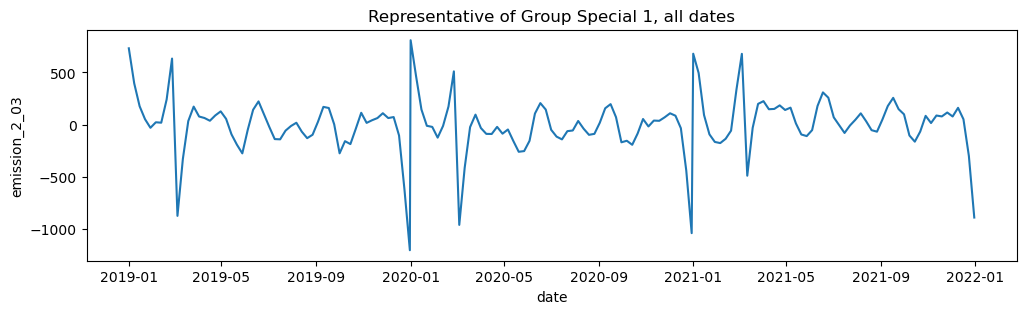

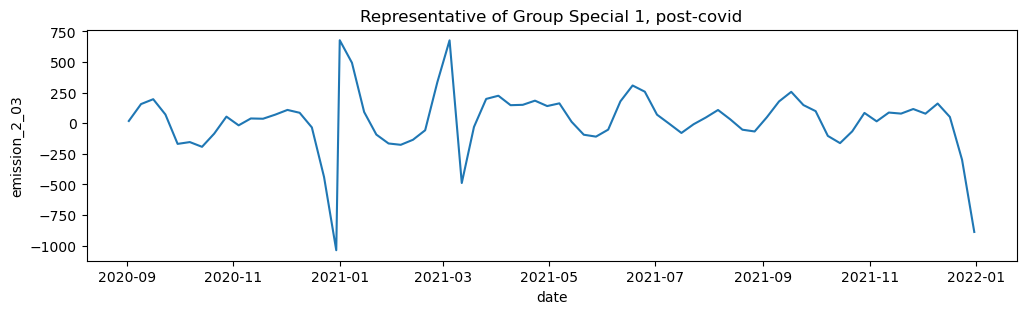

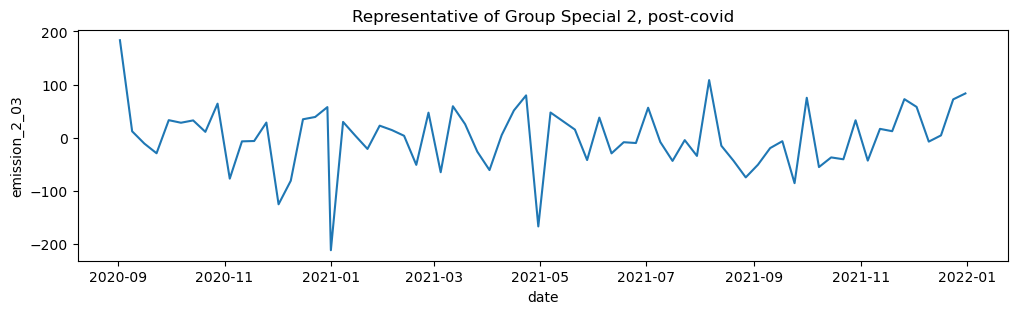

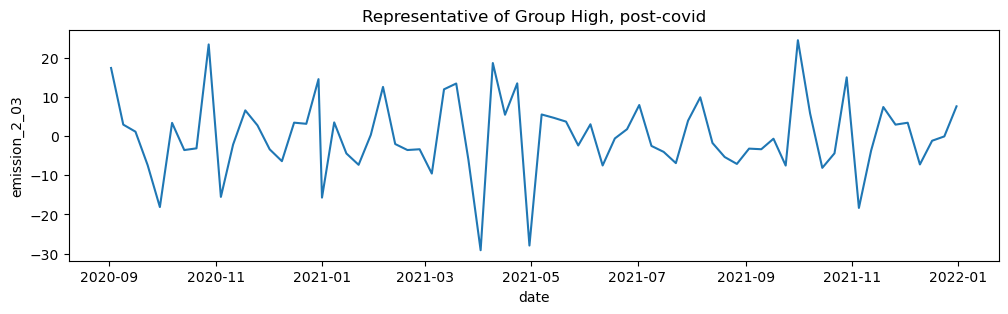

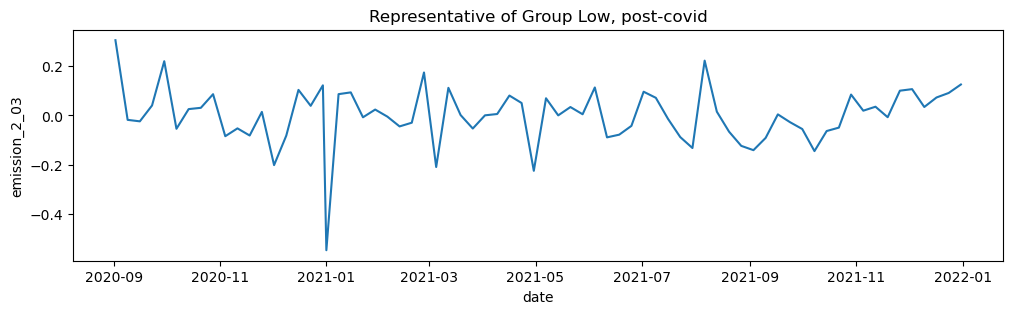

CPU times: total: 781 ms
Wall time: 949 ms


In [86]:
%%time

fig, ax = plt.subplots(figsize=(12, 3))
    
sns.lineplot(data = train_full[train_full["Location"] == four_representatives.iloc[0,0]], x='date', y='emission_2_03').\
        set(title='Representative of Group {}, all dates'.format(four_representatives.iloc[0,1]))
plt.show()

for i, representative in four_representatives.iterrows():
    
    fig, ax = plt.subplots(figsize=(12, 3))
    
    sns.lineplot(data = train[train["Location"] == representative['Location']], x='date', y='emission_2_03').\
            set(title='Representative of Group {}, post-covid'.format(representative["Group"]))
    plt.show()

We still have a yearly pattern in Special 1.

## 04. Week Effect

Let's compare different years of Special 1 residues (a straight line will represent no covid data):

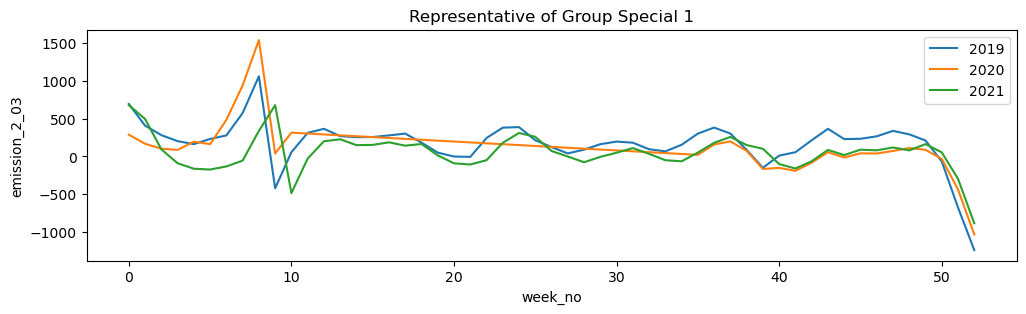

CPU times: total: 203 ms
Wall time: 209 ms


In [87]:
%%time

study_number = '04'

train_nocovid = pd.concat([train_precovid, train])

representative = four_representatives.iloc[0, :]
    
fig, ax = plt.subplots(figsize=(12, 3))
for year in [2019, 2020, 2021]:
    sns.lineplot(data = train_nocovid[(train_nocovid["Location"] == representative['Location']) &
                             (train_nocovid['year'] == year)], x='week_no', y='emission_2_03', label=year).\
            set(title='Representative of Group {}'.format(representative["Group"]))
plt.show()

Yearly patterns match. Let's remove medians for every week of the year. We won't use covid data in calculating medians.

In [88]:
%%time

week_effects = pd.pivot_table(train_nocovid, columns='Location', index='week_no', values='emission_2_03',
                             aggfunc=np.median)

week_effects_special_1 = week_effects[representative["Location"]]

for data in [train_precovid, train, train_full, test]:
    data['WeekEffect'] = 0
                                            
    data.loc[data['Location'] == representative["Location"], 'WeekEffect'] = \
                data.loc[data['Location'] == representative["Location"], 'week_no'].map(week_effects_special_1)


CPU times: total: 31.2 ms
Wall time: 42.6 ms


Let's calculate a new target and prepare a submission:

In [89]:
for data in [train_precovid, train, train_full]:
    data['emission_2_' + study_number] = data['emission'] - data['Trend'] - data['Seasonality'] - data['Seasonality_2'] \
            - data['Seasonality_3'] - data['WeekEffect']
    data['emission_pred_2_' + study_number] = data['Trend'] + data['Seasonality'] + data['Seasonality_2'] \
            + data['Seasonality_3'] + data['WeekEffect']
    
test['emission_pred_2_' + study_number] = test['Trend'] + test['Seasonality'] + test['Seasonality_2'] \
            + test['Seasonality_3'] + test['WeekEffect']

train_nocovid = pd.concat([train_precovid, train])
    
train.head()

,latitude,longitude,year,week_no,emission,Location_group,date,Location,Trend,emission_2_00,...,emission_pred_2_01,Seasonality_2,emission_2_02,emission_pred_2_02,Seasonality_3,emission_2_03,emission_pred_2_03,WeekEffect,emission_2_04,emission_pred_2_04
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2020_35,-0.51,29.29,2020,35,4.820261,Low,2020-09-02,-0.5129.29,4.200676,0.619586,...,4.536875,-0.024551,0.307937,4.512325,0.001838,0.306099,4.514163,0.0,0.306099,4.514163
ID_-0.510_29.290_2020_36,-0.51,29.29,2020,36,4.592424,Low,2020-09-09,-0.5129.29,4.206273,0.386151,...,4.547750,0.061376,-0.016702,4.609126,0.001112,-0.017815,4.610239,0.0,-0.017815,4.610239
ID_-0.510_29.290_2020_37,-0.51,29.29,2020,37,4.580510,Low,2020-09-16,-0.5129.29,4.211870,0.368640,...,4.540036,0.074348,-0.033873,4.614383,-0.010013,-0.023860,4.604370,0.0,-0.023860,4.604370
ID_-0.510_29.290_2020_38,-0.51,29.29,2020,38,4.566356,Low,2020-09-23,-0.5129.29,4.217467,0.348889,...,4.513225,-0.004415,0.057546,4.508810,0.016849,0.040697,4.525659,0.0,0.040697,4.525659
ID_-0.510_29.290_2020_39,-0.51,29.29,2020,39,4.605026,Low,2020-09-30,-0.5129.29,4.223064,0.381962,...,4.466554,-0.068100,0.206573,4.398453,-0.014171,0.220744,4.384283,0.0,0.220744,4.384283


Let's look at prediction plots for our representatives:

Group: Special 1


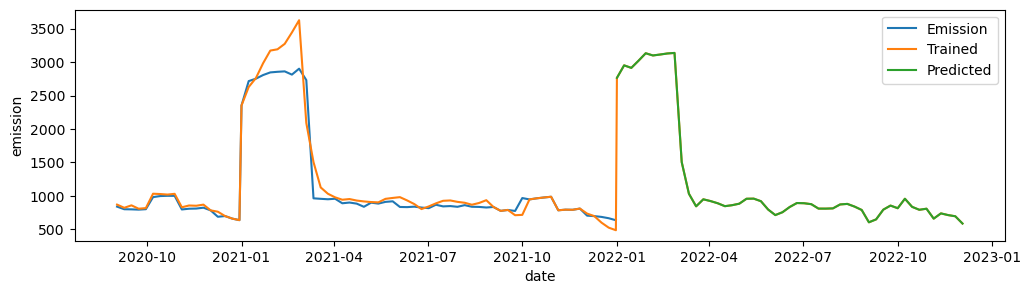

Group: Special 2


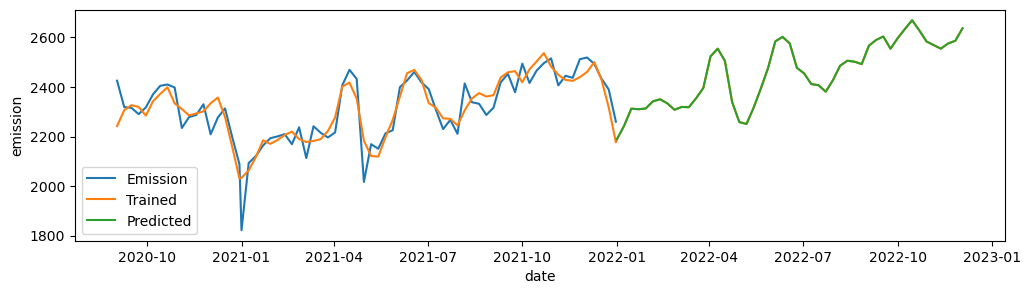

Group: High


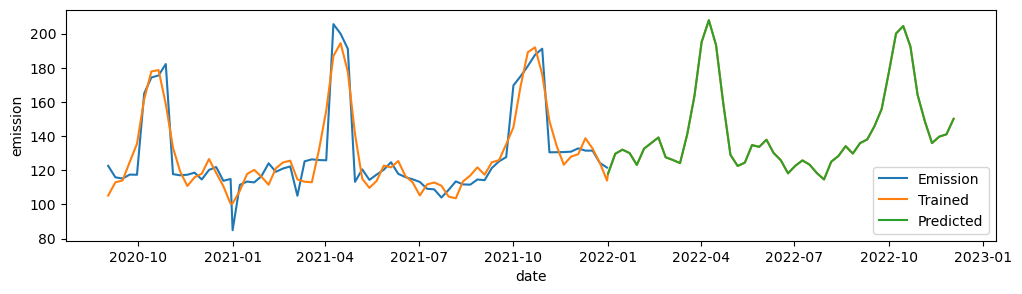

Group: Low


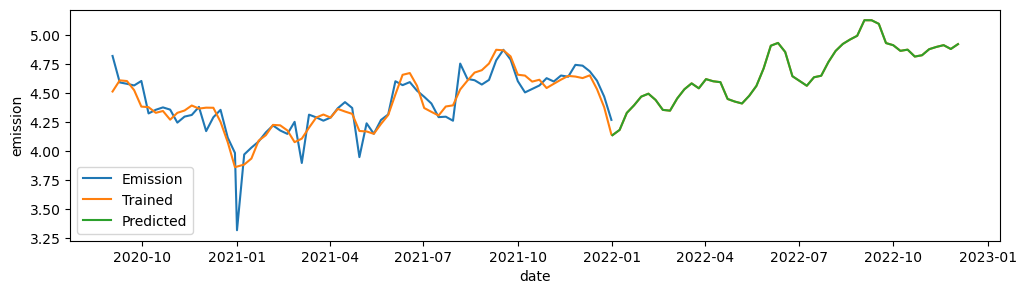

CPU times: total: 734 ms
Wall time: 964 ms


In [90]:
%%time

train_and_test = pd.concat([train, test])

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.lineplot(data = train[train['Location'] == location],
                 x='date', y='emission', label='Emission')
    sns.lineplot(data = train_and_test[train_and_test['Location'] == location],
                 x='date', y='emission_pred_2_{}'.format(study_number), label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='date', 
                 y='emission_pred_2_{}'.format(study_number), label='Predicted')
    plt.show()
    

Let's make a submission and look at the RMSEs:

In [91]:
# Calculate train RMSE
score_train = mean_squared_error(train['emission'], train['emission_pred_2_{}'.format(study_number)], squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.index, \
                           'emission': test['emission_pred_2_{}'.format(study_number)]})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [92]:
# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = '+ WeekEffect'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Test RMSE'] = 26.88799

scores_df

,Comment,Train RMSE,Test RMSE
0,Trend,39.010435,70.22941
1,+ Seasonality,16.224511,28.26862
2,+ Seasonality_2,15.360794,27.78780
3,+ Seasonality_3,15.284127,NaN
4,+ WeekEffect,12.931049,26.88799


## Cycles

Let's explore lags of our residues (the four representatives). We'll use a few functions by Ryan Holbrook.

Group: Special 1


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


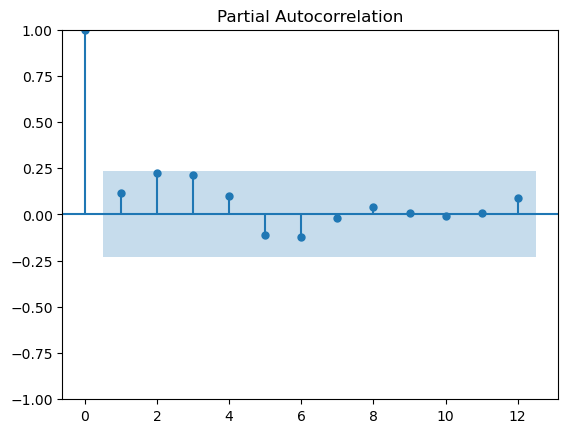

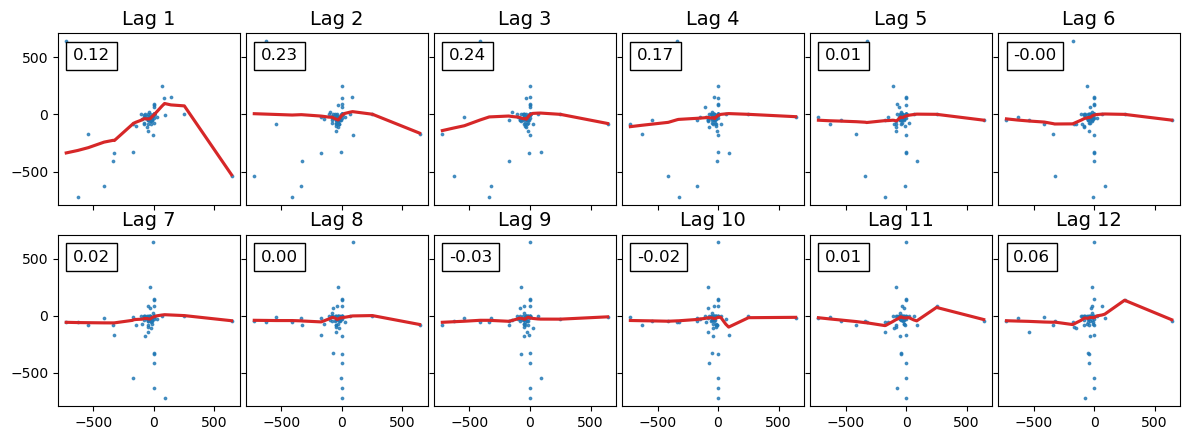

Group: Special 2


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


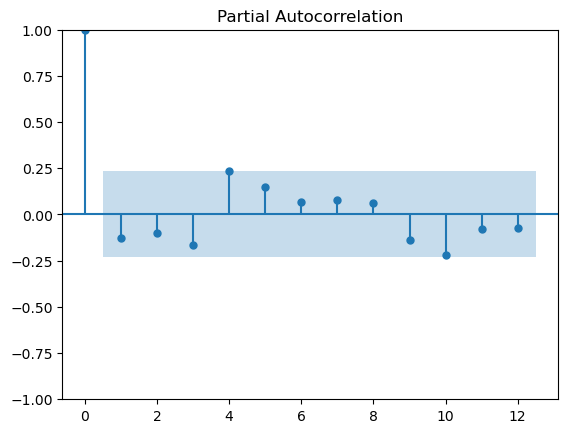

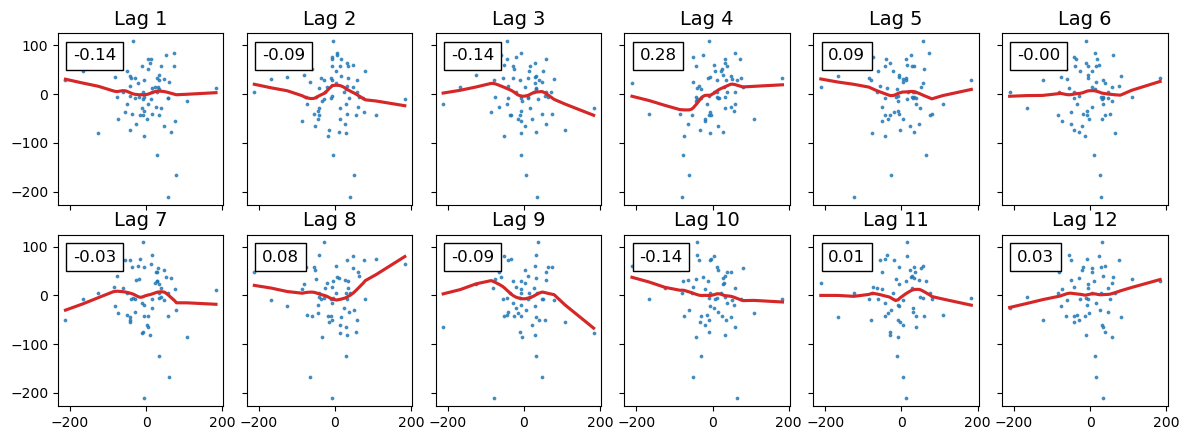

Group: High


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


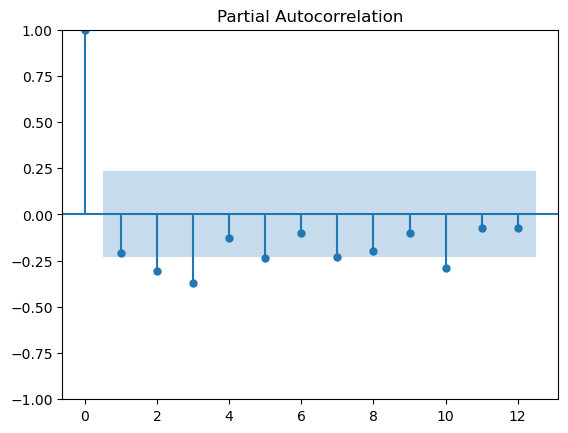

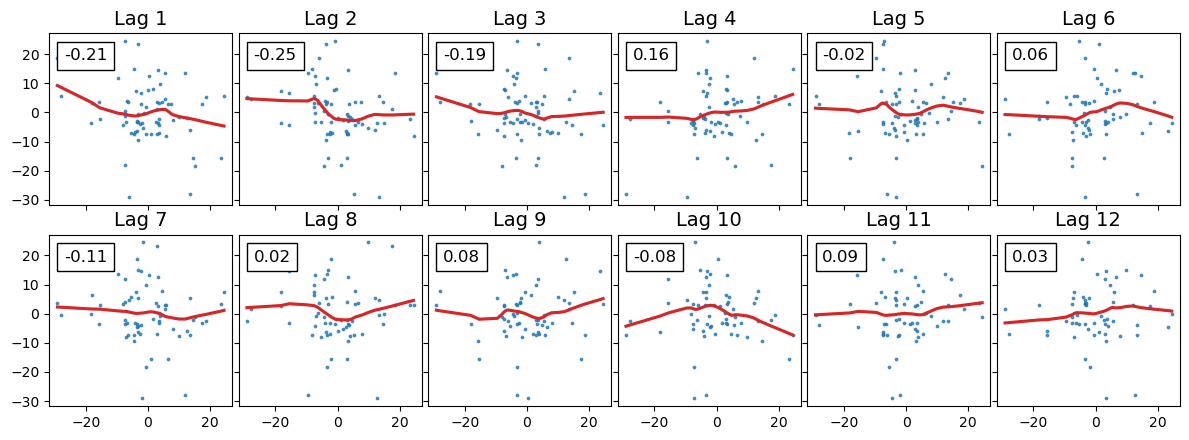

Group: Low


C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


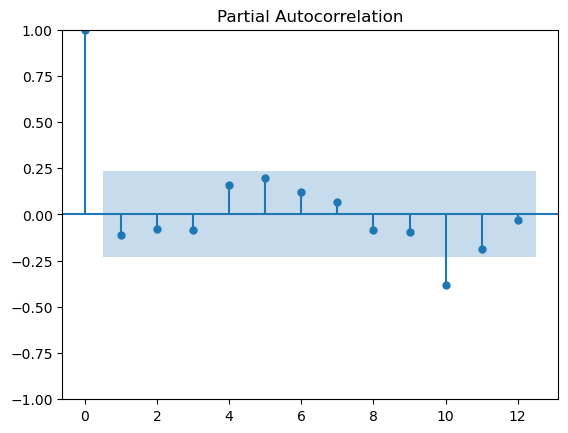

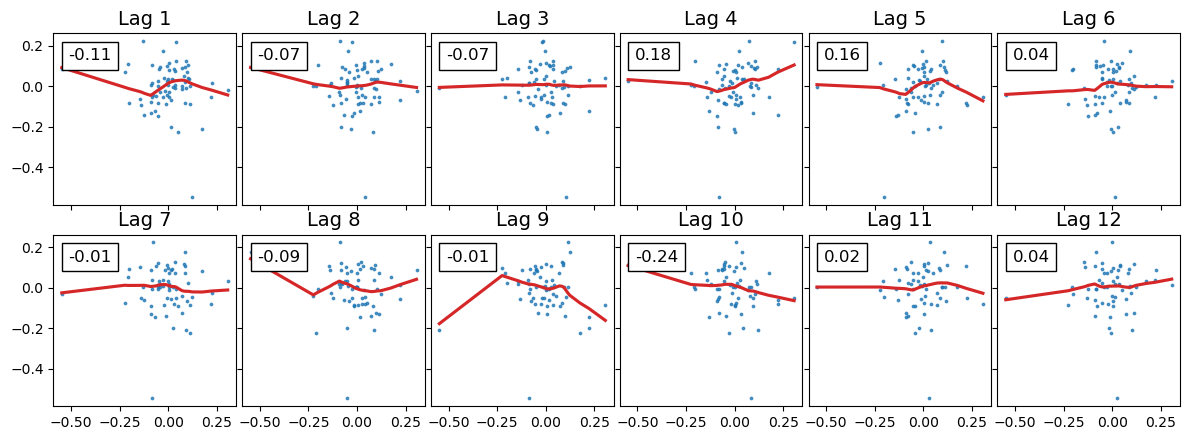

CPU times: total: 5.97 s
Wall time: 6.82 s


In [93]:
%%time

study_number = '05'

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

LAGS = 6 * 2

for i, representative in four_representatives.iterrows():
    print('Group: ' + representative['Group'])
    location = representative['Location']
    series = pd.Series(train.loc[train['Location'] == location, 'emission_2_04'].values, \
                   index=train.loc[train['Location'] == location, 'date'])
    _ = plot_pacf(series, lags=LAGS)
    _ = plot_lags(series, lags=LAGS, nrows= round(LAGS / 6))
    plt.show()




I think, removing cycles won't be beneficial in this case.

Let's export our results:

In [94]:
train_nocovid.to_csv('new_datasets/train_nocovid_2_final')
test.to_csv('new_datasets/test_2_final')